## Outline of notebook
In this notebook, we solve a simple diffusion equation to compare its solution with the Monte Carlo method implemented in another file. The focus is not on the specific constants but rather on the general shape of the solution. The results demonstrate that the solution to this partial differential equation shares the same attributes as the Monte Carlo solution. However, it is significantly smoother and computationally faster.

Let's import some packages we will use

In [8]:
import fenics
import numpy as np
import meshio
import matplotlib.pyplot as plt

We begin by creating the computational mesh for the finite difference method. The file `circle.msh` defines the desired mesh structure, which represents a unit circle. The following cell will generate the actual computational mesh based on this definition file.

In [9]:
# Load .msh file
msh = meshio.read("mesh/circle.msh")

# Extract mesh
triangle_cells = msh.cells_dict.get("triangle")
line_cells = msh.cells_dict.get("line")

# Optional: physical data
triangle_data = msh.cell_data_dict.get("gmsh:physical", {}).get("triangle", None)
line_data = msh.cell_data_dict.get("gmsh:physical", {}).get("line", None)

# Create XDMF mesh
meshio.write("mesh/circle.xdmf", meshio.Mesh(
    points=msh.points,
    cells=[("triangle", triangle_cells)],
    cell_data={"name_to_read": [triangle_data]} if triangle_data is not None else {}
))

Now we define the initial condition. In this case, all mosquitoes are assumed to be precisely at the boundary, consistent with the setup in the Monte Carlo simulation.

In [10]:
# Define the initial condition
class InitialCondition(fenics.UserExpression):
    def __init__(self, r, **kwargs):
        super().__init__(**kwargs)
        self.r = r

    def eval(self, values, x):
        radius = np.sqrt(x[0]**2 + x[1]**2)
        values[0] = 1.0 if radius > self.r else 0.0

    def value_shape(self):
        return ()

# Set the radius threshold
r = 0.99

Now we define the remaining components. To solve the PDE, we rewrite it into its variational form, which is required for the finite element method framework. This transformation does not alter the problem but reformulates it to fit the computational approach.

We also define the boundary condition, assuming that there is always a population of mosquitoes at the boundary. This reflects the assumption that the population outside the circle remains constant, even if some mosquitoes fly into the domain.

Finally, we assign the initial condition to the solution, ensuring consistency with the setup.

In [11]:
# Load mesh from XDMF
mesh = fenics.Mesh()
with fenics.XDMFFile("mesh/circle.xdmf") as xdmf:
    xdmf.read(mesh)

# Function space
V = fenics.FunctionSpace(mesh, "CG", 1)

# Define variational problem for the stationary solution
u = fenics.TrialFunction(V)
v = fenics.TestFunction(V)
f = fenics.Constant(0.0)

# Dirichlet boundary condition (u = 1 on the boundary)
boundary_condition = fenics.DirichletBC(V, fenics.Constant(1.0), "on_boundary")

a = u * v * fenics.dx + fenics.Constant(0.05) * fenics.dot(fenics.grad(u), fenics.grad(v)) * fenics.dx
L = f * v * fenics.dx

# Assign the initial condition to the solution
u = fenics.Function(V)  # Ensure u is a Function
initial_condition = fenics.Function(V)
initial_condition.interpolate(InitialCondition(r, degree=1))
u.assign(initial_condition)

Now we solve it.

In [12]:
# Solve the stationary problem
fenics.solve(a == L, u, boundary_condition)

Solving linear variational problem.


Next, we extract the solution from the computed mesh to visualize it using Matplotlib.

In [13]:
# Extract the mesh coordinates and solution values
coordinates = mesh.coordinates()
solution_values = u.compute_vertex_values(mesh)

Finally, we visualize the solution and save the plot for comparison with the Monte Carlo simulation results.

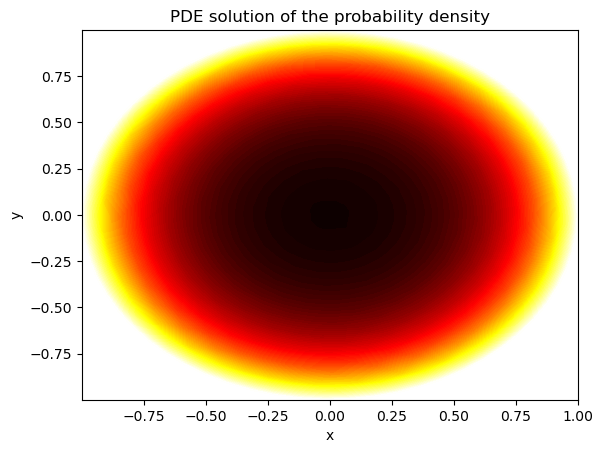

In [14]:
# Create a heatmap
heatmap = plt.tricontourf(coordinates[:, 0], coordinates[:, 1], solution_values, levels=100, cmap='hot')

# Add labels and title
plt.xlabel("x")
plt.ylabel("y")
plt.title("PDE solution of the probability density")

plt.savefig("PDE solution")
plt.show()

The solution reveals that, as expected, the probability of finding a mosquito decreases as we move closer to the center of the circle. This aligns with our goal, as it indicates that the center is the optimal location to place our tent for minimal mosquito presence.